# Mixture Density Network

Reproducing the classic Bishop MDN network tasks in Keras. The idea in this task is to predict a the value of an inverse sine function. This function has multiple real-valued solutions at each point, so the ANN model needs to have the capacity to handle this in it's loss function. An MDN is a good way to handle the predictions of these multiple output values.

There's a couple of other versions of this task, and this implementation owes much to the following:

- [David Ha - Mixture Density Networks with TensorFlow](http://blog.otoro.net/2015/11/24/mixture-density-networks-with-tensorflow/)
- [Mixture Density Networks in Edward](http://edwardlib.org/tutorials/mixture-density-network)

In [1]:
# Normal imports for everybody
import keras
from context import * # imports the MDN layer 
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib notebook

Using TensorFlow backend.


## Generate Synthetic Data

Data generation

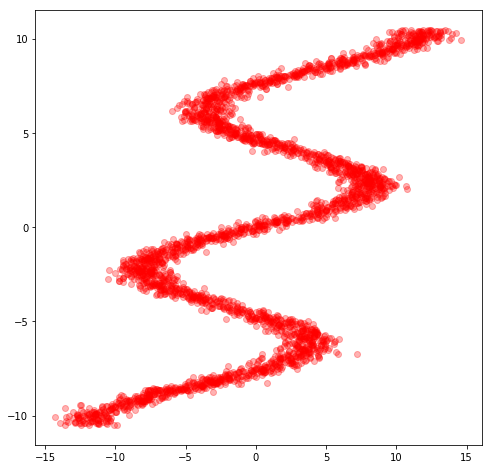

In [2]:
## Generating some data:
NSAMPLE = 3000

y_data = np.float32(np.random.uniform(-10.5, 10.5, NSAMPLE))
r_data = np.random.normal(size=NSAMPLE)
x_data = np.sin(0.75 * y_data) * 7.0 + y_data * 0.5 + r_data * 1.0
x_data = x_data.reshape((NSAMPLE, 1))

plt.figure(figsize=(8, 8))
plt.plot(x_data,y_data,'ro', alpha=0.3)
plt.show()

## Build the MDN Model

Now we will construct the MDN model in Keras. This uses the `Sequential` model interface in Keras.

The `MDN` layer comes after one or more `Dense` layers. You need to define the output dimension and number of mixtures for the MDN like so: `MDN(output_dimension, number_mixtures)`.

For this problem, we only need an output dimension of 1 as we are predicting one value (y). Adding more mixtures adds a more parameters (model is more complex, takes longer to train), but might help make the solutions better. You can see from the training data that there are at maximum 5 different layers to predict in the curve, so setting `N_MIXES = 5` is a good place to start.

For MDNs, we have to use a special loss function that can handle the mixture parameters: the function has to take into account the number of output dimensions and mixtures.

In [3]:
N_HIDDEN = 15
N_MIXES = 10

model = keras.Sequential()
model.add(keras.layers.Dense(N_HIDDEN, batch_input_shape=(None, 1), activation='relu'))
model.add(keras.layers.Dense(N_HIDDEN, activation='relu'))
model.add(mdn.MDN(1, N_MIXES))
model.compile(loss=mdn.get_mixture_loss_func(1,N_MIXES), optimizer=keras.optimizers.Adam()) #, metrics=[mdn.get_mixture_mse_accuracy(1,N_MIXES)])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 15)                30        
_________________________________________________________________
dense_2 (Dense)              (None, 15)                240       
_________________________________________________________________
mdn_1 (MDN)                  (None, 1)                 480       
Total params: 750
Trainable params: 750
Non-trainable params: 0
_________________________________________________________________


### Training the model

Now we train the model using Keras' normal `fit` command.

In [4]:
history = model.fit(x=x_data, y=y_data, batch_size=128, epochs=500, validation_split=0.15)

Train on 2550 samples, validate on 450 samples
Epoch 1/500
2550/2550 [==============================] - 2s 637us/step - loss: 6.7906 - val_loss: 5.8121
Epoch 2/500
2550/2550 [==============================] - 0s 37us/step - loss: 5.4402 - val_loss: 4.8386
Epoch 3/500
2550/2550 [==============================] - 0s 36us/step - loss: 4.6292 - val_loss: 4.2392
Epoch 4/500
2550/2550 [==============================] - 0s 35us/step - loss: 4.1021 - val_loss: 3.8306
Epoch 5/500
2550/2550 [==============================] - 0s 35us/step - loss: 3.7570 - val_loss: 3.5910
Epoch 6/500
2550/2550 [==============================] - 0s 33us/step - loss: 3.5447 - val_loss: 3.4231
Epoch 7/500
2550/2550 [==============================] - 0s 35us/step - loss: 3.4000 - val_loss: 3.3090
Epoch 8/500
2550/2550 [==============================] - 0s 36us/step - loss: 3.3052 - val_loss: 3.2367
Epoch 9/500
2550/2550 [==============================] - 0s 35us/step - loss: 3.2409 - val_loss: 3.1828
Epoch 10/500
255

2550/2550 [==============================] - 0s 38us/step - loss: 2.0391 - val_loss: 2.0708
Epoch 79/500
2550/2550 [==============================] - 0s 35us/step - loss: 2.0467 - val_loss: 2.1134
Epoch 80/500
2550/2550 [==============================] - 0s 36us/step - loss: 2.0591 - val_loss: 2.0570
Epoch 81/500
2550/2550 [==============================] - 0s 34us/step - loss: 2.0154 - val_loss: 2.0790
Epoch 82/500
2550/2550 [==============================] - 0s 33us/step - loss: 2.0271 - val_loss: 2.0337
Epoch 83/500
2550/2550 [==============================] - 0s 36us/step - loss: 1.9941 - val_loss: 2.0507
Epoch 84/500
2550/2550 [==============================] - 0s 36us/step - loss: 1.9910 - val_loss: 2.0268
Epoch 85/500
2550/2550 [==============================] - 0s 36us/step - loss: 1.9813 - val_loss: 2.0147
Epoch 86/500
2550/2550 [==============================] - 0s 36us/step - loss: 1.9855 - val_loss: 2.0237
Epoch 87/500
2550/2550 [==============================] - 0s 37us/st

2550/2550 [==============================] - 0s 32us/step - loss: 1.8081 - val_loss: 1.8413
Epoch 156/500
2550/2550 [==============================] - 0s 32us/step - loss: 1.8202 - val_loss: 1.8035
Epoch 157/500
2550/2550 [==============================] - 0s 32us/step - loss: 1.7976 - val_loss: 1.8018
Epoch 158/500
2550/2550 [==============================] - 0s 32us/step - loss: 1.7923 - val_loss: 1.8449
Epoch 159/500
2550/2550 [==============================] - 0s 32us/step - loss: 1.8084 - val_loss: 1.8128
Epoch 160/500
2550/2550 [==============================] - 0s 33us/step - loss: 1.7882 - val_loss: 1.7902
Epoch 161/500
2550/2550 [==============================] - 0s 32us/step - loss: 1.7767 - val_loss: 1.7750
Epoch 162/500
2550/2550 [==============================] - 0s 32us/step - loss: 1.7719 - val_loss: 1.7846
Epoch 163/500
2550/2550 [==============================] - 0s 32us/step - loss: 1.7683 - val_loss: 1.7854
Epoch 164/500
2550/2550 [==============================] - 0

2550/2550 [==============================] - 0s 33us/step - loss: 1.5029 - val_loss: 1.5417
Epoch 233/500
2550/2550 [==============================] - 0s 31us/step - loss: 1.4995 - val_loss: 1.5530
Epoch 234/500
2550/2550 [==============================] - 0s 31us/step - loss: 1.4950 - val_loss: 1.5594
Epoch 235/500
2550/2550 [==============================] - 0s 31us/step - loss: 1.5040 - val_loss: 1.5554
Epoch 236/500
2550/2550 [==============================] - 0s 31us/step - loss: 1.5032 - val_loss: 1.5504
Epoch 237/500
2550/2550 [==============================] - 0s 31us/step - loss: 1.4968 - val_loss: 1.5375
Epoch 238/500
2550/2550 [==============================] - 0s 31us/step - loss: 1.4902 - val_loss: 1.5473
Epoch 239/500
2550/2550 [==============================] - 0s 31us/step - loss: 1.4980 - val_loss: 1.5440
Epoch 240/500
2550/2550 [==============================] - 0s 31us/step - loss: 1.4946 - val_loss: 1.5482
Epoch 241/500
2550/2550 [==============================] - 0

2550/2550 [==============================] - 0s 38us/step - loss: 1.4461 - val_loss: 1.5165
Epoch 310/500
2550/2550 [==============================] - 0s 34us/step - loss: 1.4535 - val_loss: 1.5041
Epoch 311/500
2550/2550 [==============================] - 0s 33us/step - loss: 1.4475 - val_loss: 1.5103
Epoch 312/500
2550/2550 [==============================] - 0s 31us/step - loss: 1.4500 - val_loss: 1.5219
Epoch 313/500
2550/2550 [==============================] - 0s 36us/step - loss: 1.4500 - val_loss: 1.5062
Epoch 314/500
2550/2550 [==============================] - 0s 35us/step - loss: 1.4482 - val_loss: 1.5359
Epoch 315/500
2550/2550 [==============================] - 0s 33us/step - loss: 1.4481 - val_loss: 1.5118
Epoch 316/500
2550/2550 [==============================] - 0s 31us/step - loss: 1.4515 - val_loss: 1.5091
Epoch 317/500
2550/2550 [==============================] - 0s 34us/step - loss: 1.4475 - val_loss: 1.5018
Epoch 318/500
2550/2550 [==============================] - 0

2550/2550 [==============================] - 0s 32us/step - loss: 1.4205 - val_loss: 1.5067
Epoch 387/500
2550/2550 [==============================] - 0s 32us/step - loss: 1.4304 - val_loss: 1.4885
Epoch 388/500
2550/2550 [==============================] - 0s 33us/step - loss: 1.4391 - val_loss: 1.4954
Epoch 389/500
2550/2550 [==============================] - 0s 35us/step - loss: 1.4289 - val_loss: 1.5251
Epoch 390/500
2550/2550 [==============================] - 0s 37us/step - loss: 1.4221 - val_loss: 1.4871
Epoch 391/500
2550/2550 [==============================] - 0s 35us/step - loss: 1.4177 - val_loss: 1.4912
Epoch 392/500
2550/2550 [==============================] - 0s 34us/step - loss: 1.4221 - val_loss: 1.5039
Epoch 393/500
2550/2550 [==============================] - 0s 35us/step - loss: 1.4195 - val_loss: 1.4899
Epoch 394/500
2550/2550 [==============================] - 0s 35us/step - loss: 1.4202 - val_loss: 1.4957
Epoch 395/500
2550/2550 [==============================] - 0

2550/2550 [==============================] - 0s 31us/step - loss: 1.4171 - val_loss: 1.5007
Epoch 464/500
2550/2550 [==============================] - 0s 31us/step - loss: 1.4114 - val_loss: 1.4761
Epoch 465/500
2550/2550 [==============================] - 0s 30us/step - loss: 1.4100 - val_loss: 1.4910
Epoch 466/500
2550/2550 [==============================] - 0s 30us/step - loss: 1.4090 - val_loss: 1.4940
Epoch 467/500
2550/2550 [==============================] - 0s 31us/step - loss: 1.4099 - val_loss: 1.4896
Epoch 468/500
2550/2550 [==============================] - 0s 30us/step - loss: 1.4137 - val_loss: 1.4814
Epoch 469/500
2550/2550 [==============================] - 0s 30us/step - loss: 1.4114 - val_loss: 1.5033
Epoch 470/500
2550/2550 [==============================] - 0s 32us/step - loss: 1.4158 - val_loss: 1.5055
Epoch 471/500
2550/2550 [==============================] - 0s 31us/step - loss: 1.4096 - val_loss: 1.5205
Epoch 472/500
2550/2550 [==============================] - 0

In [5]:
# Save model if you want to.
# model.save("MDN-1D-sine-prediction-model.h5")

In [6]:
# Load the model if you want to.
# To load models from file, you need to supply the layer and loss function as custom_objects:
# model = keras.models.load_model('MDN-1D-sine-prediction-model.h5', custom_objects={'MDN': mdn.MDN, 'loss_func': mdn.get_mixture_loss_func(1, N_MIXES)})

### Training and Validation Loss

It's interesting to see how the model trained. We can see that after a certain point training is rather slow.

For this problem a loss value around 1.5 produces quite good results.

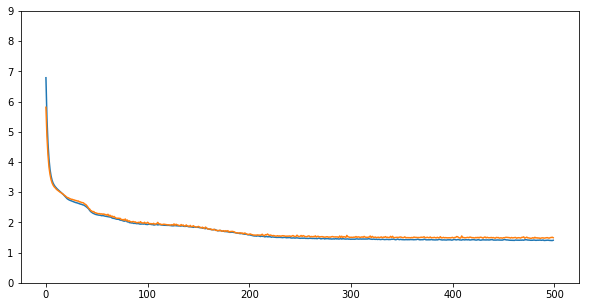

In [7]:
plt.figure(figsize=(10, 5))
plt.ylim([0,9])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

## Sampling Functions

The MDN model outputs parameters of a mixture model---a list of means (mu), variances (sigma), and weights (pi).

The `mdn` module provides a function to sample from these parameters as follows. First the parameters are split up into `mu`s, `sigma`s and `pi`s, then the categorical distribution formed by the `pi`s is sampled to choose which mixture component should be sampled, then that component's `mu`s and `sigma`s is used to sample from a multivariate normal model, here's the code:

    def sample_from_output(params, output_dim, num_mixes, temp=1.0):
        """Sample from an MDN output with temperature adjustment."""
        mus = params[:num_mixes*output_dim]
        sigs = params[num_mixes*output_dim:2*num_mixes*output_dim]
        pis = softmax(params[-num_mixes:], t=temp)
        m = sample_from_categorical(pis)
        # Alternative way to sample from categorical:
        # m = np.random.choice(range(len(pis)), p=pis)
        mus_vector = mus[m*output_dim:(m+1)*output_dim]
        sig_vector = sigs[m*output_dim:(m+1)*output_dim] * temp  # adjust for temperature
        cov_matrix = np.identity(output_dim) * sig_vector
        sample = np.random.multivariate_normal(mus_vector, cov_matrix, 1)
        return sample
        
If you only have one prediction to sample from, you can use the function as is; but if you need to sample from a lot of predictions at once (as in the following sections), you can use `np.apply_along_axis` to apply it to a whole numpy array of predicted parameters.

## Try out the MDN Model

Now we try out the model by making predictions at 3000 evenly spaced points on the x-axis. 

Mixture models output lists of parameters, so we're going to sample from these parameters for each point on the x-axis, and also try plotting the parameters themselves so we can have some insight into what the model is learning!

In [8]:
## Sample on some test data:
x_test = np.float32(np.arange(-15,15,0.01))
NTEST = x_test.size
print("Testing:", NTEST, "samples.")
x_test = x_test.reshape(NTEST,1) # needs to be a matrix, not a vector

# Make predictions from the model
y_test = model.predict(x_test)
# y_test contains parameters for distributions, not actual points on the graph.
# To find points on the graph, we need to sample from each distribution.

# Sample from the predicted distributions
y_samples = np.apply_along_axis(mdn.sample_from_output, 1, y_test, 1, N_MIXES,temp=1.0)

# Split up the mixture parameters (for future fun)
mus = np.apply_along_axis((lambda a: a[:N_MIXES]),1, y_test)
sigs = np.apply_along_axis((lambda a: a[N_MIXES:2*N_MIXES]),1, y_test)
pis = np.apply_along_axis((lambda a: mdn.softmax(a[2*N_MIXES:])),1, y_test)

Testing: 3000 samples.


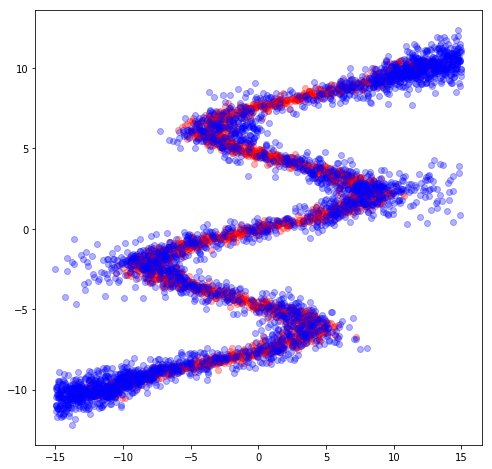

In [10]:
# Plot the samples
plt.figure(figsize=(8, 8))
plt.plot(x_data,y_data,'ro', x_test, y_samples[:,:,0], 'bo',alpha=0.3)
plt.show()
# These look pretty good!

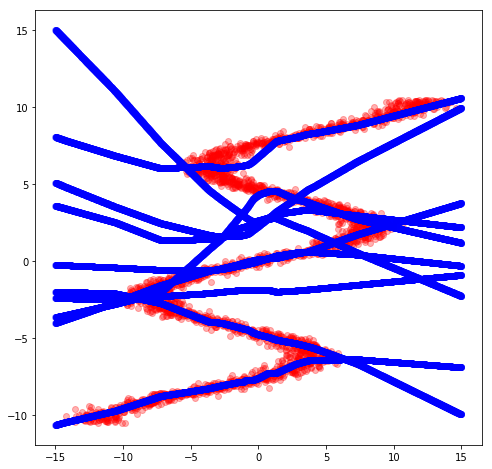

In [11]:
# Plot the means - this gives us some insight into how the model learns to produce the mixtures.
plt.figure(figsize=(8, 8))
plt.plot(x_data,y_data,'ro', x_test, mus,'bo',alpha=0.3)
plt.show()
# Cool!

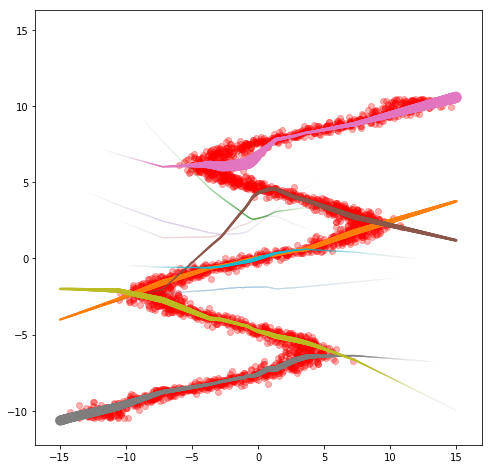

In [12]:
# Let's plot the variances and weightings of the means as well.
fig = plt.figure(figsize=(8, 8))
ax1 = fig.add_subplot(111)
# ax1.scatter(data[0], data[1], marker='o', c='b', s=data[2], label='the data')
ax1.scatter(x_data,y_data,marker='o', c='r', alpha=0.3)
for i in range(N_MIXES):
    ax1.scatter(x_test, mus[:,i], marker='o', s=200*sigs[:,i]*pis[:,i],alpha=0.3)
plt.show()